In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
plt.figure();
import mplhep
plt.style.use(mplhep.style.CMS)
#mplhep.style.use("CMS")


<Figure size 432x288 with 0 Axes>

In [2]:

allowedCapSelectVals=np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
                                 13,  14,  15,  24,  25,  26,  27,  28,  29,  30,  31,  56,  57,
                                 58,  59,  60,  61,  62,  63, 120, 121, 122, 123, 124, 125, 126,
                                 127, 248, 249, 250, 251, 252, 253, 254, 255, 504, 505, 506, 507,
                                 508, 509, 510, 511])
allowedCapSelectVals_map=np.zeros(512,dtype=int)
for i,j in enumerate(allowedCapSelectVals):
    allowedCapSelectVals_map[j]=i

IRRADIATION_START_TIME=np.datetime64('2022-09-26 14:45')

In [3]:
def parseLogFile(fName):
    _f=open(f'logs/{fName}')
    _fLines=_f.read()
    matches=re.findall(r'09-(.*) INFO   Power: On, Voltage: (.*) V, Current: (.*) A, Temp: (.*) C, Res.: (.*) Ohms\n09.* Word count (\d*), error count (\d*)',_fLines)
    matches=np.array(matches)

    output={}
    dates=pd.to_datetime(['09-'+x for x in matches[:,0]])
    voltage=np.float32(matches[:,1])
    current=np.float32(matches[:,2])
    temp=np.float32(matches[:,3])
    rtd_resistance=np.float32(matches[:,4])
    badReadings=(voltage==-1)&(current==-1)
    voltage[badReadings]=np.nan
    current[badReadings]=np.nan
    badReadings=(temp==-1)&(rtd_resistance==-1)
    temp[badReadings]=np.nan
    rtd_resistance[badReadings]=np.nan
    comparisons=np.float32(matches[:,5])
    errors=np.float32(matches[:,6])
    errorRate=errors/comparisons
    matches=re.findall(r'09-.* RW M.*\n09-(.*) INFO   Power: On, Voltage: (.*) V, Current: (.*) A, Temp: (.*) C, Res.: (.*) Ohms\n09.* Word count (\d*), error count (\d*)',_fLines)
    matches=np.array(matches)
    datesI2C=pd.to_datetime(['09-'+x for x in matches[:,0]])
    isI2C=dates.isin(datesI2C)
    t0=((dates.values-IRRADIATION_START_TIME).astype(int)/3.6e12)
    t0[t0<0]=0
    TID=t0*5.51

    output['time']=dates
    output['TID']=TID
    output['voltage']=voltage
    output['current']=current
    output['temp']=temp
    output['rtd']=rtd_resistance
    output['nComp']=comparisons
    output['nErr']=errors
    output['isI2C']=isI2C
    
    re_string="09-(.*) INFO   Good PLL settings V=(.*): \[(.*)\]"

    matches=re.findall(re_string,_fLines)
    matches=np.array(matches)
    output['PLLscan_time']=pd.to_datetime(['09-'+x for x in matches[:,0]])
    output['PLLscan_voltage']=np.float32(matches[:,1])
#     output['PLLscan_nGoodSettings']=np.array([len(eval(x[2])) for x in matches])
#     output['PLLscan_minGoodSetting']=np.array([min(eval(x[2])) for x in matches])
#     output['PLLscan_maxGoodSettings']=np.array([max(eval(x[2])) for x in matches])

    t0=(output['PLLscan_time'].values-IRRADIATION_START_TIME).astype(int)/3.6e12
    t0[t0<0]=0
    TID=t0*5.51
    output['PLLscan_TID']=TID

    re_string="09-(.*) INFO   Good PLL settings V=(.*):|09-(.*) INFO.     CapSel=(\d+), V=(.*), PUSM=(\d)"
    matches=re.findall(re_string,_fLines)
    matches=np.array(matches)

    dates=[]
    pllFull=[]
    pll=[]
    v=[]
    for m in matches:
        if not m[0]=='':
            time='09-'+m[0]
            dates.append(time)
            v.append(float(m[1]))
            pllFull.append([])
            pll.append([])
        else:
            pllFull.append(int(m[-3]))
            if m[-1]=='9':
                pll[-1].append(int(m[-3]))

#     output['PLLscan_time']=[]
#     output['PLLscan_voltage']=[]
    output['PLLscan_nGoodSettings']=[]
    output['PLLscan_minGoodSetting']=[]
    output['PLLscan_maxGoodSettings']=[]
    output['PLLscan_choice']=[]
    for i in range(len(dates)):
#         output['PLLscan_time'].append(dates[i])
#         output['PLLscan_voltage'].append(v[i])
        output['PLLscan_nGoodSettings'].append(len(pll[i]))
        if len(pll[i])>0:
            output['PLLscan_maxGoodSettings'].append(max(pll[i]))
            output['PLLscan_minGoodSetting'].append(min(pll[i]))
            j=int(len(pll[i])/3)
            output['PLLscan_choice'].append(pll[i][j])
        else:
            output['PLLscan_maxGoodSettings'].append(-1)
            output['PLLscan_minGoodSetting'].append(-1)
            output['PLLscan_choice'].append(-1)
    output['PLLscan_minGoodSetting']=np.array(output['PLLscan_minGoodSetting'])
    output['PLLscan_choice']=np.array(output['PLLscan_choice'])
    output['PLLscan_maxGoodSettings']=np.array(output['PLLscan_maxGoodSettings'])

#     output['PLLscan2_time']=pd.to_datetime(np.array(output['PLLscan2_time']))

    re_string='09-(.*) INFO   Setting PLL VCO CapSelect to (\d*) with phaseSelect settings of (\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*)'
    matches=re.findall(re_string,_fLines)
    matches=np.array(matches)
    output['PLLscan_used']=np.ones_like(output['PLLscan_time'],dtype=int)-2
    output['PLLscan_used'][output['PLLscan_voltage']==1.2] = matches[:,1]
    output['PLLscan_bestPhase'] = np.ones(len(output['PLLscan_time'])*12,dtype=int).reshape(-1,12)-2
    output['PLLscan_bestPhase'][output['PLLscan_voltage']==1.2] = matches[:,2:]


    re_string="09(.*) INFO.  Starting Power Scans \( timestamp (.*) \)"
    matches=re.findall(re_string,_fLines)
    matches=np.array(matches)
    output['PLL_timestamp_time']=pd.to_datetime(['09-'+x for x in matches[:,0]])
    output['PLL_timestamp']=np.array(matches[:,1])
#     pd.to_datetime(['09-'+x for x in matches[:,0]])
#     output['']
    return output
    

In [4]:
coolDown=parseLogFile('logFile_Chip10_CoolDown.log')
startIrr=parseLogFile('logFile_Chip10_StartIrradiation.log')
# IrrSept28_v1=parseLogFile('logFile_Chip10_StartIrradiation_Sept28_05h28.log')
# IrrSept28_v2=parseLogFile('logFile_Chip10_StartIrradiation_Sept28_05h58.log')
# IrrSept28_v3=parseLogFile('logFile_Chip10_StartIrradiation_Sept28_07h05.log')
IrrSept28_v4=parseLogFile('logFile_Chip10_StartIrradiation_Sept28_07h23.log')
IrrSept28_v5=parseLogFile('logFile_Chip10_StartIrradiation_Sept28_14h14.log')

IrrSept28_v6=parseLogFile('logFile_Chip10_StartIrradiation_Sept28_16h43.log')
# IrrSept28_v7=parseLogFile('logFile_Chip10_StartIrradiation_Sept28_16h59.log')
IrrSept28_v8=parseLogFile('logFile_Chip10_StartIrradiation_Sept28_17h19.log')
IrrSept28_v9=parseLogFile('logFile_Chip10_StartIrradiation_Sept28_20h16.log')


In [5]:
#define pandas dataframes for different log types
dfList=[]
for d in [coolDown,startIrr,IrrSept28_v4,IrrSept28_v5,IrrSept28_v6,IrrSept28_v8,IrrSept28_v9]:
    dfList.append(pd.DataFrame({x:d[x] for x in ['TID', 'voltage', 'current', 'temp', 'rtd', 'nComp', 'nErr', 'isI2C']},index=d['time']))
dfErr=pd.concat(dfList)

columns=['PLLscan_voltage', 'PLLscan_TID', 'PLLscan_nGoodSettings', 'PLLscan_minGoodSetting', 'PLLscan_maxGoodSettings', 'PLLscan_choice', 'PLLscan_used']# 'PLLscan_bestPhase']
dfList=[]
for d in [coolDown,startIrr,IrrSept28_v4,IrrSept28_v5,IrrSept28_v6,IrrSept28_v8,IrrSept28_v9]:
    dfList.append(pd.DataFrame({x.replace('PLLscan_',''):d[x] for x in columns},index=d['PLLscan_time']))

dfPLL=pd.concat(dfList)
# dfPLL.drop(dfPLL[dfPLL.nGoodSettings==0].index,inplace=True)

dfPLL['choice_idx']=allowedCapSelectVals_map[dfPLL.choice.values]
dfPLL['used_idx']=allowedCapSelectVals_map[dfPLL.used.values]

dfList=[]
for d in [coolDown,startIrr,IrrSept28_v4,IrrSept28_v5,IrrSept28_v6,IrrSept28_v8,IrrSept28_v9]:
    dfList.append(pd.DataFrame({'timestamp':d['PLL_timestamp']},index=d['PLL_timestamp_time']))
dfTimestamp=pd.concat(dfList)
dfPLL.loc[dfPLL.voltage==1.08,'timestamp']=dfTimestamp.timestamp.values
dfPLL.timestamp.ffill(inplace=True)


(17.0, 25.0)

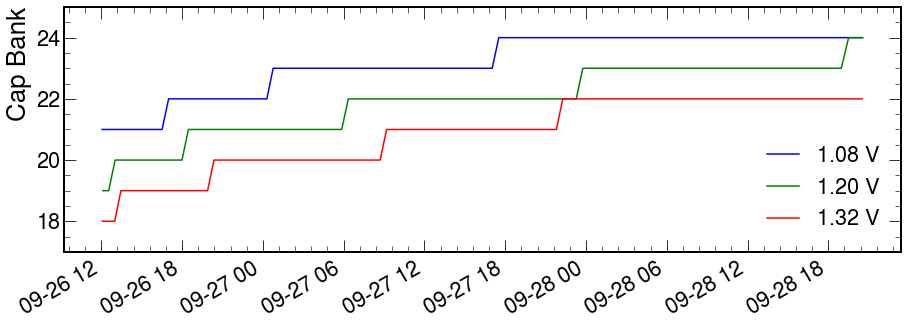

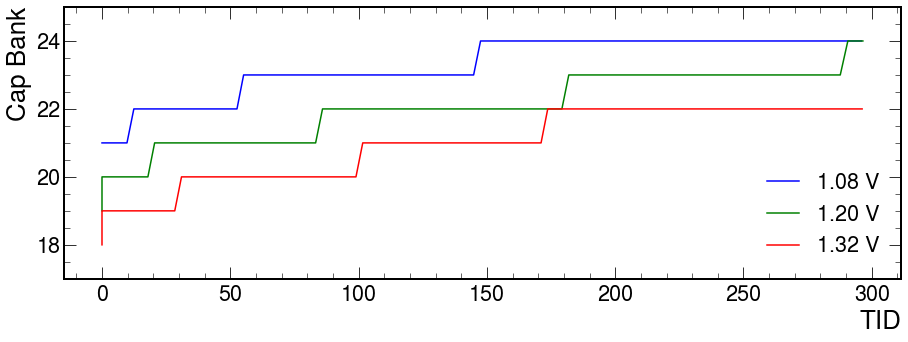

In [6]:
x=dfPLL.loc['2022-09-26 12:03':]
fig,ax=plt.subplots(1,1,figsize=(15,5))
x[x.voltage==1.08].plot(y='choice_idx',ax=ax,color='blue',label='1.08 V')
x[x.voltage==1.2].plot(y='choice_idx',ax=ax,color='green',label='1.20 V')
x[x.voltage==1.32].plot(y='choice_idx',ax=ax,color='red',label='1.32 V')
ax.set_ylabel('Cap Bank')
ax.set_ylim(17,25)
fig,ax=plt.subplots(1,1,figsize=(15,5))
x[x.voltage==1.08].plot(x='TID',y='choice_idx',ax=ax,color='blue',label='1.08 V')
x[x.voltage==1.2].plot(x='TID',y='choice_idx',ax=ax,color='green',label='1.20 V')
x[x.voltage==1.32].plot(x='TID',y='choice_idx',ax=ax,color='red',label='1.32 V')
ax.set_ylabel('Cap Bank')
ax.set_ylim(17,25)


(17.0, 25.0)

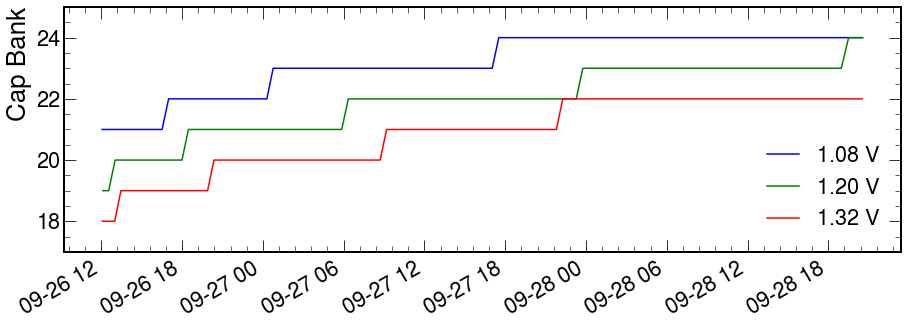

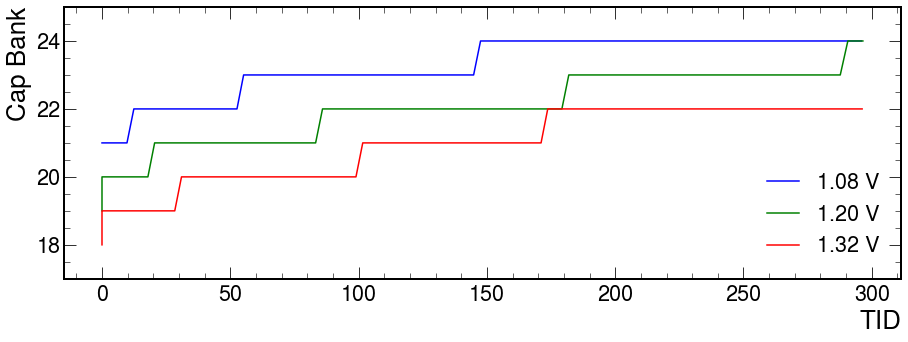

In [7]:
x=dfPLL.loc['2022-09-26 12:03':]
fig,ax=plt.subplots(1,1,figsize=(15,5))
x[x.voltage==1.08].plot(y='choice_idx',ax=ax,color='blue',label='1.08 V')
x[x.voltage==1.2].plot(y='choice_idx',ax=ax,color='green',label='1.20 V')
x[x.voltage==1.32].plot(y='choice_idx',ax=ax,color='red',label='1.32 V')
ax.set_ylabel('Cap Bank')
ax.set_ylim(17,25)
fig,ax=plt.subplots(1,1,figsize=(15,5))
x[x.voltage==1.08].plot(x='TID',y='choice_idx',ax=ax,color='blue',label='1.08 V')
x[x.voltage==1.2].plot(x='TID',y='choice_idx',ax=ax,color='green',label='1.20 V')
x[x.voltage==1.32].plot(x='TID',y='choice_idx',ax=ax,color='red',label='1.32 V')
ax.set_ylabel('Cap Bank')
ax.set_ylim(17,25)


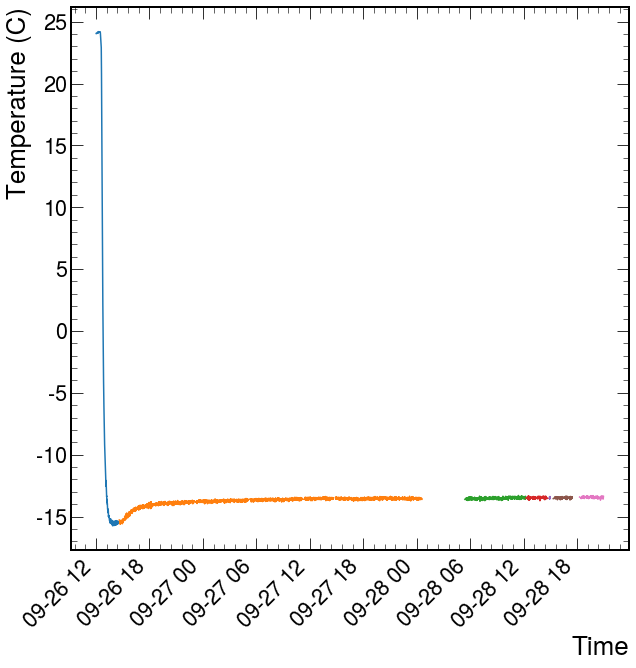

In [8]:
plt.figure()
plt.plot(coolDown['time'],coolDown['temp'])
plt.plot(startIrr['time'],startIrr['temp'])
plt.plot(IrrSept28_v4['time'],IrrSept28_v4['temp'])
plt.plot(IrrSept28_v5['time'],IrrSept28_v5['temp'])
plt.plot(IrrSept28_v6['time'],IrrSept28_v6['temp'])
plt.plot(IrrSept28_v8['time'],IrrSept28_v8['temp'])
plt.plot(IrrSept28_v9['time'],IrrSept28_v9['temp'])
plt.xlabel('Time')
plt.ylabel('Temperature (C)');
plt.xticks(rotation=45, ha='right');


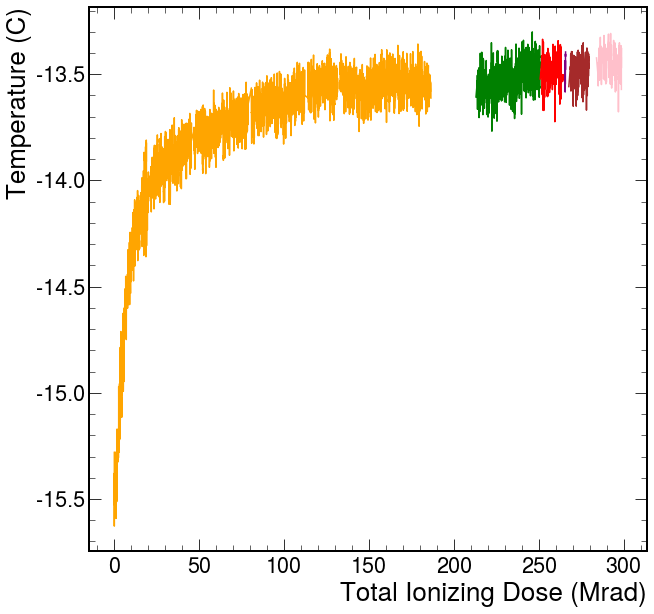

In [9]:
plt.plot(startIrr['TID'],startIrr['temp'],color='orange')
plt.plot(IrrSept28_v4['TID'],IrrSept28_v4['temp'],color='green')
plt.plot(IrrSept28_v5['TID'],IrrSept28_v5['temp'],color='red')
plt.plot(IrrSept28_v6['TID'],IrrSept28_v6['temp'],color='purple')
plt.plot(IrrSept28_v8['TID'],IrrSept28_v8['temp'],color='brown')
plt.plot(IrrSept28_v9['TID'],IrrSept28_v9['temp'],color='pink')
plt.xlabel('Total Ionizing Dose (Mrad)')
plt.ylabel('Temperature (C)');
# plt.xticks(rotation=45, ha='right');


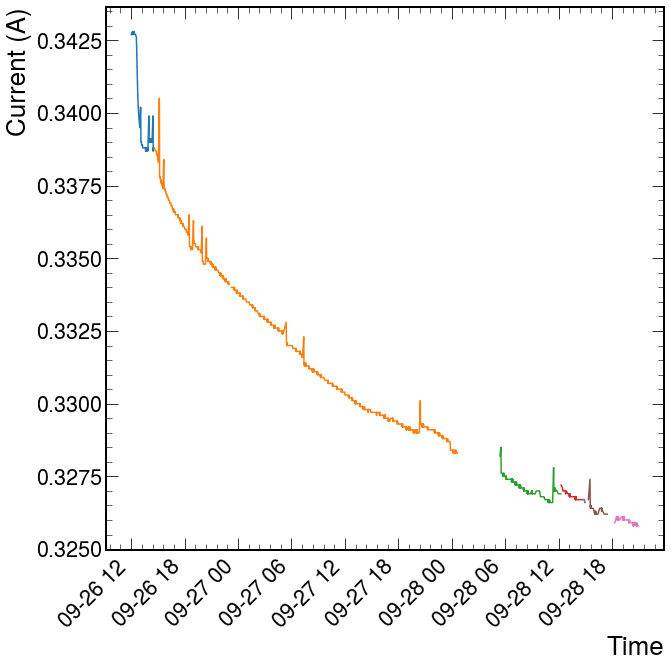

In [10]:
plt.plot(coolDown['time'],coolDown['current'])
plt.plot(startIrr['time'],startIrr['current'])
plt.plot(IrrSept28_v4['time'],IrrSept28_v4['current'])
plt.plot(IrrSept28_v5['time'],IrrSept28_v5['current'])
plt.plot(IrrSept28_v6['time'],IrrSept28_v6['current'])
plt.plot(IrrSept28_v8['time'],IrrSept28_v8['current'])
plt.plot(IrrSept28_v9['time'],IrrSept28_v9['current'])
plt.xlabel('Time')
plt.ylabel('Current (A)')
plt.xticks(rotation=45, ha='right');


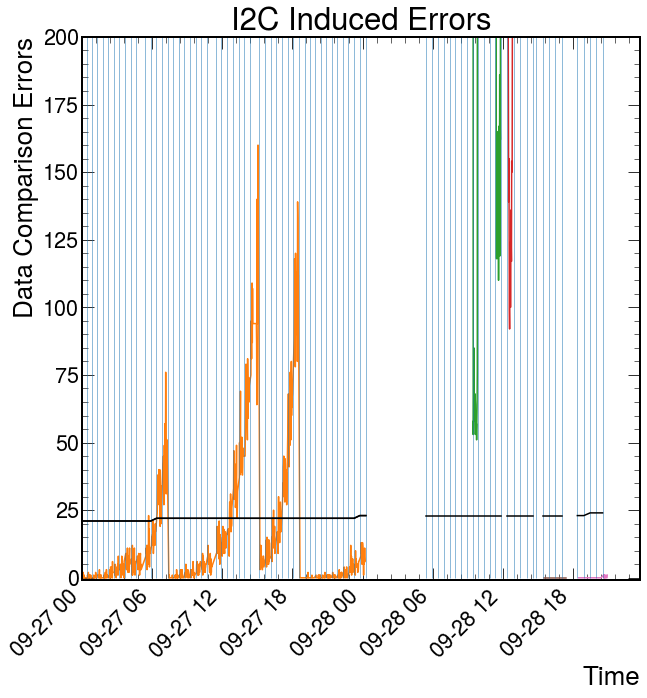

In [11]:
# cut=((coolDown['nErr']/coolDown['nComp'])<.9)&coolDown['isI2C']
# plt.plot(coolDown['time'][cut],coolDown['nErr'][cut])
# cut=((startIrr['nErr']/startIrr['nComp'])<.9)&startIrr['isI2C']
# plt.plot(startIrr['time'][cut],startIrr['nErr'][cut])
# cut=((IrrSept28_v4['nErr']/IrrSept28_v4['nComp'])<.9)&IrrSept28_v4['isI2C']
# plt.plot(IrrSept28_v4['time'][cut],IrrSept28_v4['nErr'][cut])
# cut=((IrrSept28_v5['nErr']/IrrSept28_v5['nComp'])<.9)&IrrSept28_v5['isI2C']
# plt.plot(IrrSept28_v5['time'][cut],IrrSept28_v5['nErr'][cut])

for d in [coolDown,startIrr,IrrSept28_v4,IrrSept28_v5,IrrSept28_v6,IrrSept28_v8,IrrSept28_v9]:
    cut=((d['nErr']/d['nComp'])<.9)&d['isI2C']
    plt.plot(d['time'][cut],d['nErr'][cut])

    cut=d['PLLscan_voltage']==1.2
    for x in d['PLLscan_time'][cut]:
        plt.vlines(x,0,200,linewidth=0.5)
    plt.plot(d['PLLscan_time'][cut],allowedCapSelectVals_map[d['PLLscan_choice'][cut]],color='k')

plt.xlabel('Time')
plt.ylabel('Data Comparison Errors')
plt.title('I2C Induced Errors')
plt.ylim(-1,200);

# for x in startIrr['PLLscan_time']:
#     plt.vlines(x,0,200)

plt.xlim(np.datetime64('2022-09-27 00'),None);

cut=startIrr['PLLscan_voltage']==1.2
plt.plot(startIrr['PLLscan_time'][cut],allowedCapSelectVals_map[startIrr['PLLscan_choice'][cut]],color='k')

plt.xticks(rotation=45, ha='right');




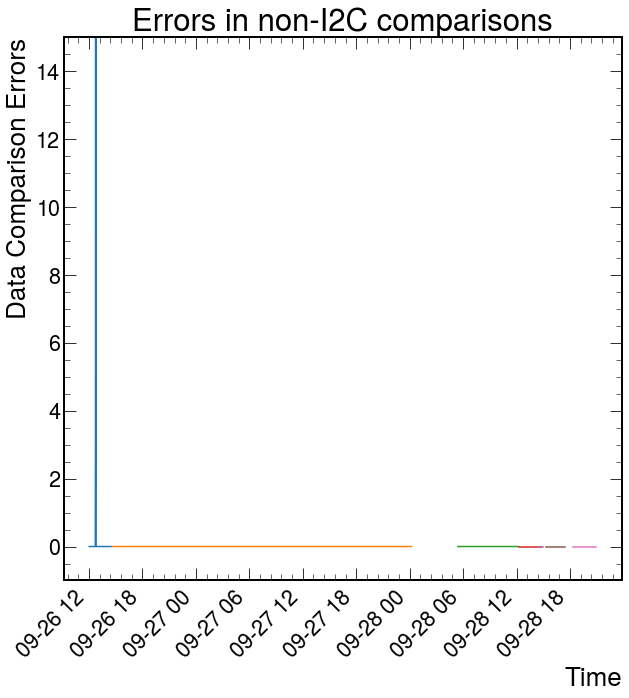

In [12]:
# d=coolDown
# cut=((d['nErr']/d['nComp'])<.9)&~d['isI2C']
# plt.plot(d['time'][cut],d['nErr'][cut])
# d=startIrr
# cut=((d['nErr']/d['nComp'])<.9)&~d['isI2C']
# plt.plot(d['time'][cut],d['nErr'][cut])
# d=IrrSept28_v4
# cut=((d['nErr']/d['nComp'])<.9)&~d['isI2C']
# plt.plot(d['time'][cut],d['nErr'][cut])
# d=IrrSept28_v5
# cut=((d['nErr']/d['nComp'])<.9)&~d['isI2C']
# plt.plot(d['time'][cut],d['nErr'][cut])

for d in [coolDown,startIrr,IrrSept28_v4,IrrSept28_v5,IrrSept28_v6,IrrSept28_v8,IrrSept28_v9]:
    cut=((d['nErr']/d['nComp'])<.9)&~d['isI2C']
    plt.plot(d['time'][cut],d['nErr'][cut])

plt.xlabel('Time')
plt.ylabel('Data Comparison Errors')
plt.title('Errors in non-I2C comparisons')
plt.ylim(-1,15)
plt.xticks(rotation=45, ha='right');

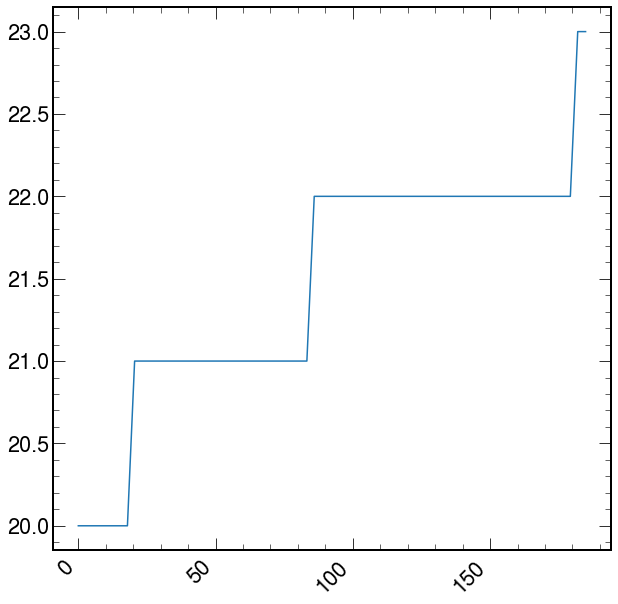

In [13]:
cut=startIrr['PLLscan_voltage']==1.2
# plt.plot(startIrr['PLLscan_time'][cut],allowedCapSelectVals_map[startIrr['PLLscan_choice'][cut]])
plt.plot(startIrr['PLLscan_TID'][cut],allowedCapSelectVals_map[startIrr['PLLscan_choice'][cut]])
plt.xticks(rotation=45, ha='right');


In [14]:
startIrr.keys()

dict_keys(['time', 'TID', 'voltage', 'current', 'temp', 'rtd', 'nComp', 'nErr', 'isI2C', 'PLLscan_time', 'PLLscan_voltage', 'PLLscan_TID', 'PLLscan_nGoodSettings', 'PLLscan_minGoodSetting', 'PLLscan_maxGoodSettings', 'PLLscan_choice', 'PLLscan_used', 'PLLscan_bestPhase', 'PLL_timestamp_time', 'PLL_timestamp'])

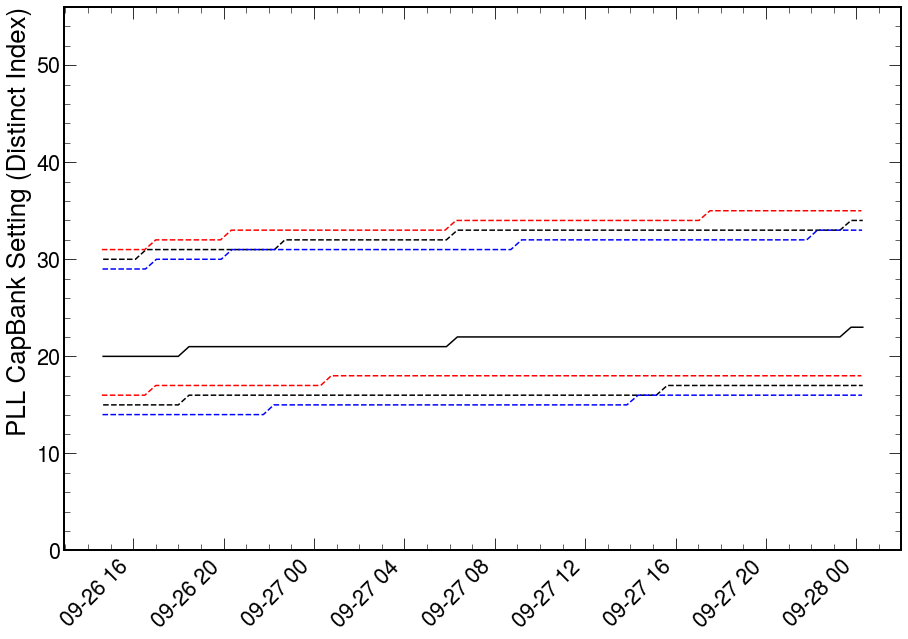

In [15]:
plt.figure(figsize=(15,10))
cut=startIrr['PLLscan_voltage']==1.2
plt.plot(startIrr['PLLscan_time'][cut],allowedCapSelectVals_map[startIrr['PLLscan_maxGoodSettings'][cut]],linestyle='--',color='k')
plt.plot(startIrr['PLLscan_time'][cut],allowedCapSelectVals_map[startIrr['PLLscan_minGoodSetting'][cut]],linestyle='--',color='k')
plt.plot(startIrr['PLLscan_time'][cut],allowedCapSelectVals_map[startIrr['PLLscan_choice'][cut]],color='k')
#print(startIrr['PLLscan_minGoodSetting'][cut])


cut=startIrr['PLLscan_voltage']==1.08
plt.plot(startIrr['PLLscan_time'][cut],allowedCapSelectVals_map[startIrr['PLLscan_maxGoodSettings'][cut]],linestyle='--',color='r')
plt.plot(startIrr['PLLscan_time'][cut],allowedCapSelectVals_map[startIrr['PLLscan_minGoodSetting'][cut]],linestyle='--',color='r')
cut=startIrr['PLLscan_voltage']==1.32
plt.plot(startIrr['PLLscan_time'][cut],allowedCapSelectVals_map[startIrr['PLLscan_maxGoodSettings'][cut]],linestyle='--',color='b')
plt.plot(startIrr['PLLscan_time'][cut],allowedCapSelectVals_map[startIrr['PLLscan_minGoodSetting'][cut]],linestyle='--',color='b')

plt.ylabel('PLL CapBank Setting (Distinct Index)')
plt.ylim(0,56)
plt.xticks(rotation=45, ha='right');

(0.0, 56.0)

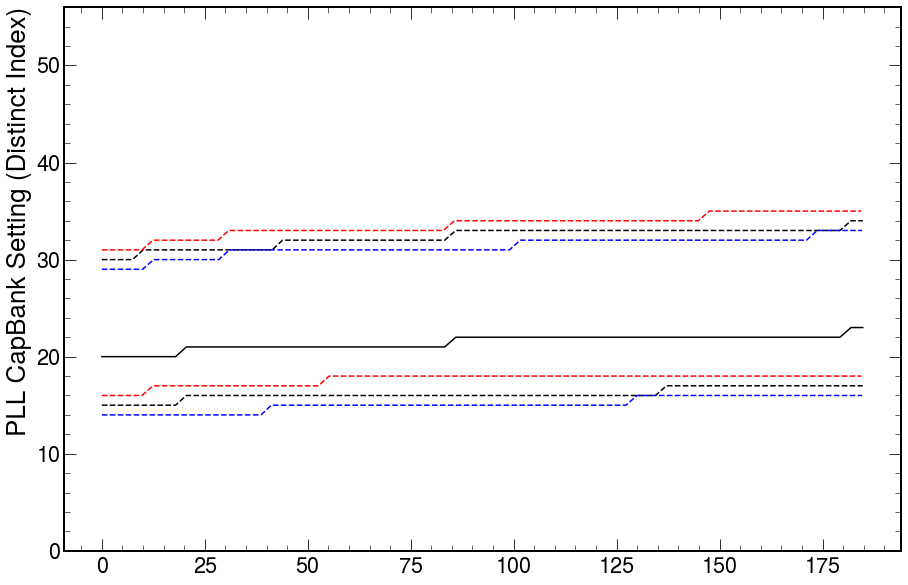

In [16]:
plt.figure(figsize=(15,10))
cut=startIrr['PLLscan_voltage']==1.2
plt.plot(startIrr['PLLscan_TID'][cut],allowedCapSelectVals_map[startIrr['PLLscan_maxGoodSettings'][cut]],linestyle='--',color='k')
plt.plot(startIrr['PLLscan_TID'][cut],allowedCapSelectVals_map[startIrr['PLLscan_minGoodSetting'][cut]],linestyle='--',color='k')
plt.plot(startIrr['PLLscan_TID'][cut],allowedCapSelectVals_map[startIrr['PLLscan_choice'][cut]],color='k')
#print(startIrr['PLLscan_minGoodSetting'][cut])


cut=startIrr['PLLscan_voltage']==1.08
plt.plot(startIrr['PLLscan_TID'][cut],allowedCapSelectVals_map[startIrr['PLLscan_maxGoodSettings'][cut]],linestyle='--',color='r')
plt.plot(startIrr['PLLscan_TID'][cut],allowedCapSelectVals_map[startIrr['PLLscan_minGoodSetting'][cut]],linestyle='--',color='r')
cut=startIrr['PLLscan_voltage']==1.32
plt.plot(startIrr['PLLscan_TID'][cut],allowedCapSelectVals_map[startIrr['PLLscan_maxGoodSettings'][cut]],linestyle='--',color='b')
plt.plot(startIrr['PLLscan_TID'][cut],allowedCapSelectVals_map[startIrr['PLLscan_minGoodSetting'][cut]],linestyle='--',color='b')

plt.ylabel('PLL CapBank Setting (Distinct Index)')
plt.ylim(0,56)

In [17]:
# _f=open('logs/LogDuringCoolDown.log')
# re_string="2022-(.*) INFO   Good PLL settings V=(.*): \[(.*)\]"

# matches=re.findall(re_string,_f.read())
# matches=np.array(matches)

# PLLscan_dates=pd.to_datetime(['2022-'+x for x in matches[:,0]])
# PLLscan_voltage=np.float32(matches[:,1])


In [18]:
# matches[:,2]

In [19]:
fName='logFile_Chip10_StartIrradiation.log'
# fName='logFile_Chip10_CoolDown.log'

_f=open(f'logs/{fName}')
_fLines=_f.read()

matches=re.findall(r"09-(.*) ERROR  RO Mismatches: {'ASIC': (.*)}",_fLines)
matches=np.array(matches)
dates=pd.to_datetime(['09-'+x for x in matches[:,0]])

y=np.zeros(len(dates)*12).reshape(-1,12)
for i in range(12):
    for j in range(len(dates)):
        try:
            y[j][i]=eval(matches[j,1])[f'CH_ALIGNER_{i}INPUT_ALL']['hdr_mm_cntr'][1]
        except:
            y[j][i]=np.nan
df1=pd.DataFrame(y,columns=[f'CH{i}_hdr_mm' for i in range(12)],index=dates)
df1=df1.fillna(method='ffill').fillna(0)

In [20]:
fName='logFile_Chip10_StartIrradiation_Sept28_07h23.log'
# fName='logFile_Chip10_CoolDown.log'

_f=open(f'logs/{fName}')
_fLines=_f.read()

matches=re.findall(r"09-(.*) ERROR  RO Mismatches: {'ASIC': (.*)}",_fLines)
matches=np.array(matches)
dates=pd.to_datetime(['09-'+x for x in matches[:,0]])

y=np.zeros(len(dates)*12).reshape(-1,12)
for i in range(12):
    for j in range(len(dates)):
        try:
            y[j][i]=eval(matches[j,1])[f'CH_ALIGNER_{i}INPUT_ALL']['hdr_mm_cntr'][1]
        except:
            y[j][i]=np.nan
df2=pd.DataFrame(y,columns=[f'CH{i}_hdr_mm' for i in range(12)],index=dates)
df2=df2.fillna(method='ffill').fillna(0)

<AxesSubplot:>

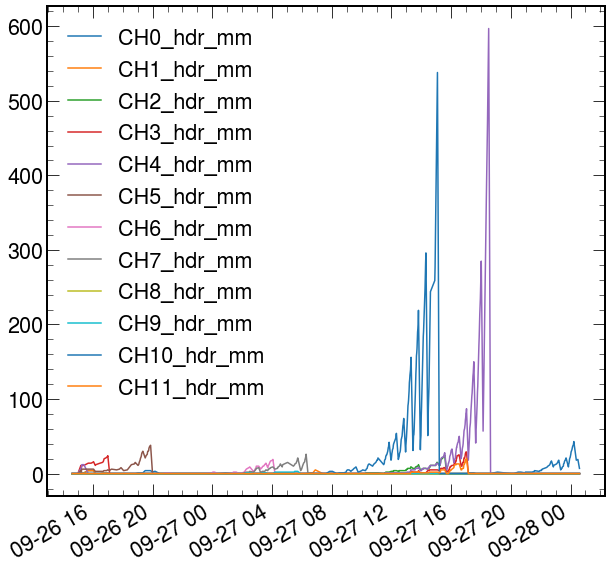

In [21]:
df1.plot(use_index=True)

<AxesSubplot:>

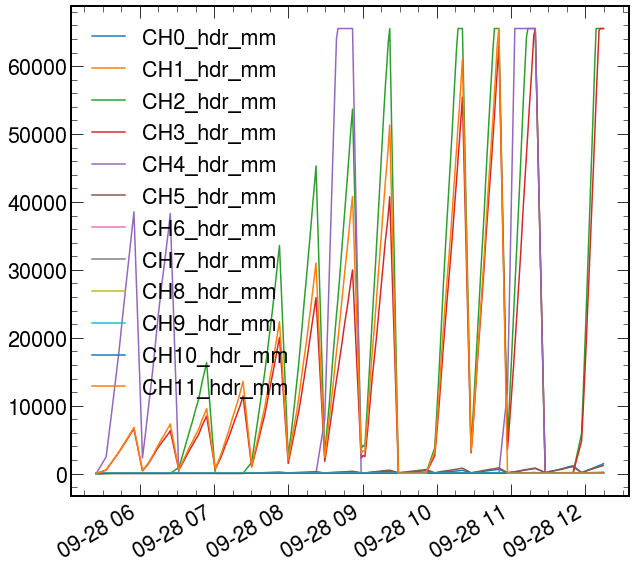

In [22]:
df2.plot(use_index=True)

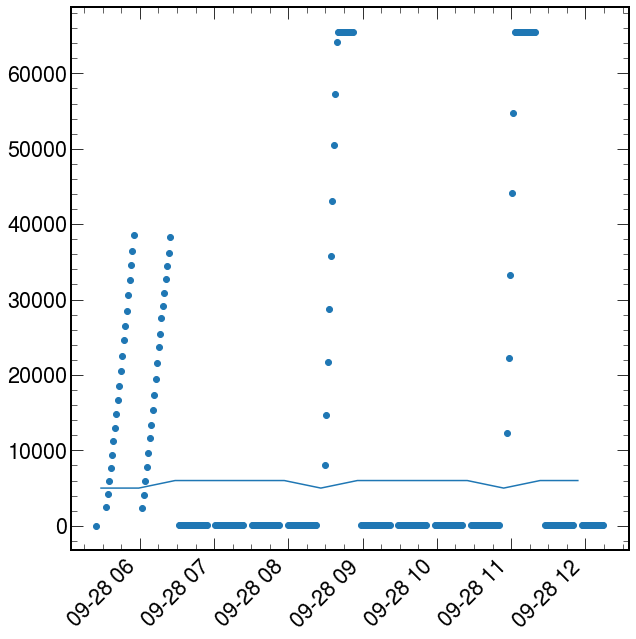

In [23]:
cut=IrrSept28_v4['PLLscan_voltage']==1.2
plt.plot(IrrSept28_v4['PLLscan_time'][cut],1000*IrrSept28_v4['PLLscan_bestPhase'][cut][:,4])

plt.scatter(df2.index.values,df2.CH4_hdr_mm.values)
plt.xticks(rotation=45, ha='right');

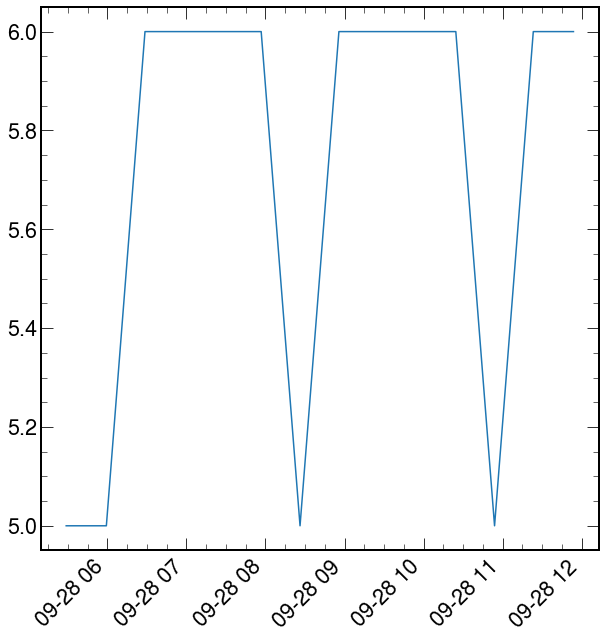

In [24]:
cut=IrrSept28_v4['PLLscan_voltage']==1.2
plt.plot(IrrSept28_v4['PLLscan_time'][cut],IrrSept28_v4['PLLscan_bestPhase'][cut][:,4])
plt.xticks(rotation=45, ha='right');


In [25]:
# re_string="09-(.*) INFO   Good PLL settings V=(.*):|09-(.*) INFO.     CapSel=(\d+), V=(.*), PUSM=(\d)"

# matches=re.findall(re_string,_fLines)
# matches=np.array(matches)

# dates=[]
# pllFull=[]
# pll=[]
# v=[]
# for m in matches:
#     if not m[0]=='':
#         time=pd.to_datetime('2022-09-'+m[0])
#         dates.append(time)
#         v.append(float(m[1]))
#         pllFull.append([])
#         pll.append([])
#     else:
#         pllFull.append(int(m[-3]))
#         if m[-1]=='9':
#             pll[-1].append(int(m[-3]))
# # PLLscan_dates=pd.to_datetime(['2022-'+x for x in matches[:,0]])
# # PLLscan_voltage=np.float32(matches[:,1])
